In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint  
from math import pi
from qutip import Options, sigmax, sigmaz, sesolve, mesolve, basis, expect, tensor, qeye, destroy, Qobj
from scipy.optimize import curve_fit
from schedule import run, generate_local_adiabatic_pulse, ramp_array, ramp, Schedule, find_eigen
import sympy as sp
from sympy.assumptions.refine import refine_abs, refine
from sympy import Q, Abs, Eq
from copy import deepcopy
from math import factorial, floor

d:\anaconda3\envs\qubit-reset\lib\site-packages\qutip\__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [2]:
def generator_element(h, j, k):
    D = sp.diag(h)
    V_jk = h[j, k]
    D_j, D_k = D[j, j], D[k, k]
    S_jk = V_jk / (D_j - D_k)
    return S_jk

def commutator(A, B):
    return A * B - B * A

def commutator_ct(A, ct_last):
    Ct = commutator(A, ct_last)
    return Ct 

def generator(V, D):
    S = sp.zeros(sp.shape(V)[0], sp.shape(V)[1])
    for j in range(V.rows):
        for k in range(V.cols):
            if V[j, k] != 0:
                s_jk = V[j, k] / (D[j, j] - D[k, k])
                S[j, k] = s_jk
    return S

def update_h(m, S, D, V):
    h = D
    Ct = commutator(S, V)
    for t in range(1, m):
        h = h + (t / sp.factorial(t+1)) * Ct
        Ct = commutator_ct(S, Ct)
    return h

def RSWT(h0, K):
    n_max = floor(np.log2(K))
    hn = h0
    h_list = [h0]
    for n in range(n_max):
        Dn = sp.diag(*hn.diagonal())
        Vn = hn - Dn
        Sn = generator(Vn, Dn)
        m = floor(K / (2 ** n))
        hn = update_h(m, Sn, Dn, Vn)
        h_list.append(hn)
    return hn, h_list   

def plot_eigen(x, h_list, plot_step=1, marker='.'):
    eigen_3ls_energies = []
    for _h in h_list:
        h_qobj = Qobj(_h)
        energies = h_qobj.eigenenergies()
        eigen_3ls_energies.append(energies)
    eigen_3ls_energies_mat = np.array(eigen_3ls_energies).T
    plt.plot(x[::plot_step], eigen_3ls_energies_mat[0][::plot_step], marker)
    plt.plot(x[::plot_step], eigen_3ls_energies_mat[1][::plot_step], marker)
    return eigen_3ls_energies_mat

In [3]:
delta = sp.Symbol('Δ', real=True, positive=True, dtype=float)
g = sp.Symbol('g', positive=True, real=True, dtype=float)
d = sp.Symbol('d', positive=True, real=True, dtype=float)

h0_tls = sp.Matrix([
[delta,      g],
[g,       -delta]])

h0_3ls = sp.Matrix([
[delta,      0,            g],
[0,       -delta,          g],
[g,            g,    d]])

In [4]:
K = 2


In [5]:
h, _ = RSWT(h0_3ls, K)
# h

In [6]:
h_eff = h[0:2, 0:2]
h_eff

Matrix([
[-g**2/(2*(d - Δ)) + g**2/(2*(-d + Δ)) + Δ,     -g**2/(2*(d + Δ)) + g**2/(2*(-d + Δ))],
[    -g**2/(2*(d - Δ)) + g**2/(2*(-d - Δ)), -g**2/(2*(d + Δ)) + g**2/(2*(-d - Δ)) - Δ]])

In [8]:
g_val = 50e-3
d_val = 150e-3
delta_sweep = np.linspace(-1.5 * g_val, 1.5 * g_val, 50) 

e1_sym_num = [h[0, 1].subs({g: g_val, delta: delta_val, d: d_val}) for delta_val in delta_sweep]
e2_sym_num = [h[1, 1].subs({g: g_val, delta: delta_val, d: d_val}) for delta_val in delta_sweep]



In [9]:
h0_list = [np.array(h0_3ls.subs({g: g_val, delta: delta_val, d: d_val})) for delta_val in delta_sweep]
h_list = [np.array(h_eff.subs({g: g_val, delta: delta_val, d: d_val})) for delta_val in delta_sweep]

In [10]:
h_list[0]

array([[-0.0861111111111111, -0.0222222222222222],
       [-0.0222222222222222, 0.0416666666666667]], dtype=object)

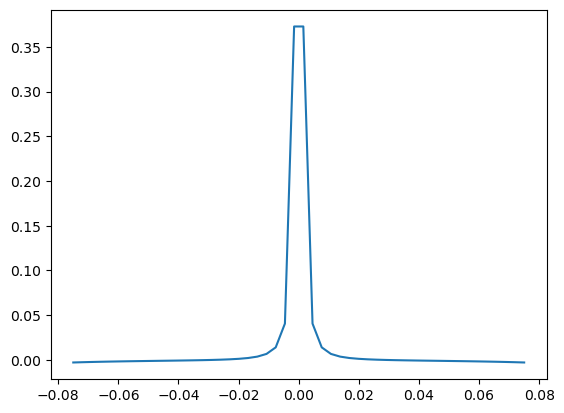

In [171]:
plt.plot(delta_sweep, e1_sym_num)
# plt.plot(delta_sweep, e2_sym_num)

plt.show()

In [11]:
type(h_list[0])

numpy.ndarray

array([[-8.63212233e-02, -8.34408936e-02, -8.05685301e-02,
        -7.77049042e-02, -7.48509142e-02, -7.20076142e-02,
        -6.91762518e-02, -6.63583165e-02, -6.35556041e-02,
        -6.07703018e-02, -5.80051036e-02, -5.52633667e-02,
        -5.25493287e-02, -4.98684114e-02, -4.72276513e-02,
        -4.46363181e-02, -4.21068106e-02, -3.96559586e-02,
        -3.73069052e-02, -3.50917553e-02, -3.30550544e-02,
        -3.12576208e-02, -2.97787747e-02, -2.87122846e-02,
        -2.81495355e-02, -2.81495355e-02, -2.87122846e-02,
        -2.97787747e-02, -3.12576208e-02, -3.30550544e-02,
        -3.50917553e-02, -3.73069052e-02, -3.96559586e-02,
        -4.21068106e-02, -4.46363181e-02, -4.72276513e-02,
        -4.98684114e-02, -5.25493287e-02, -5.52633667e-02,
        -5.80051036e-02, -6.07703018e-02, -6.35556041e-02,
        -6.63583165e-02, -6.91762518e-02, -7.20076142e-02,
        -7.48509142e-02, -7.77049042e-02, -8.05685301e-02,
        -8.34408936e-02, -8.63212233e-02],
       [ 5.34

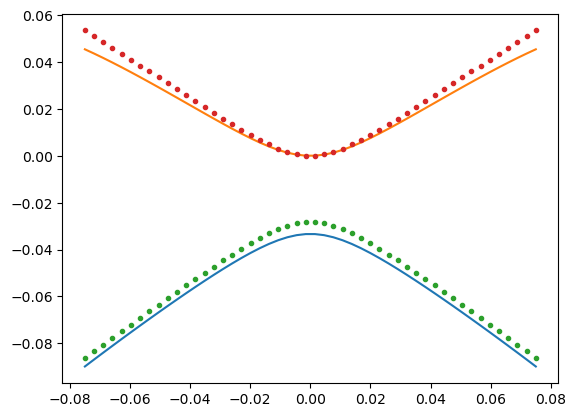

In [12]:
plot_eigen(delta_sweep, h_list, marker='-')
plot_eigen(delta_sweep, h0_list)
